<a href="https://colab.research.google.com/github/tugcegurbuz/Pytorch/blob/master/TransferLearning_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** Transfer learning with MNIST and AlexNet

---

In [0]:
import torch
import torchvision

In [0]:
#Define batch sizes
batch_size_train = 64
batch_size_test = 1000

In [3]:
#MNIST data is 1 channel 28x28 sized. To be able to feed this data into AlexNet,
#we need to transform it into 3 channels and resize it.

img_size = 64

#Load training and test data and do the transformations
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Lambda(lambda img: img.convert(mode='RGB').resize((img_size, img_size)) ),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Lambda(lambda img: img.convert(mode='RGB').resize((img_size, img_size))  ),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20984511.96it/s]                            


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 327459.37it/s]
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5200146.81it/s]                           
8192it [00:00, 129174.38it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [4]:
#Let's see an example from test loader. The output means that, we have 1000 examples
#in each batch with 3 channels and 64x64 pixel size
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 64, 64])

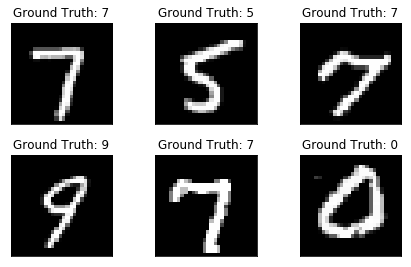

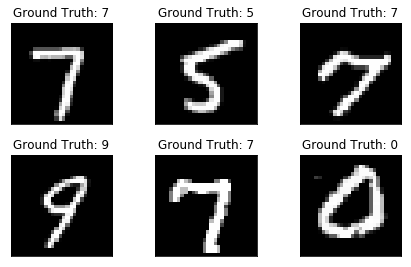

In [5]:
#Let's see some examples from the data

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
#Get actual data
train_data = torchvision.datasets.MNIST('/files/', train=True, transform=None, download=False)
test_data = torchvision.datasets.MNIST('/files/', train=False, transform=None, download=False)

#Store dataloaders and dataset sizes
dataloaders = {'train': train_loader, 'val':test_loader}
dataset_sizes = {'train': len(train_data), 'val':len(test_data)}

In [7]:
#Get AlexNet model
model_conv = torchvision.models.alexnet(pretrained=True)
print(model_conv)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:02<00:00, 81841549.39it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
#Freeze all layers except the last one

for param in model_conv.parameters():
    param.requires_grad = False 

In [0]:
import torch.nn as nn

# Number of features in the bottleneck layer
num_ftrs = model_conv.classifier[6].in_features

#Substitute it with a new fully connected layer with the same number of inputs but only 10 outputs
#Since this MNIST dataset and different from the ImageNet, we are using a linear classifier
model_conv.classifier[6] = nn.Linear(num_ftrs, 10)

In [0]:
import torch.optim as optim

# define cross entropy loss
criterion = nn.CrossEntropyLoss()

# define the optimizer. Note that we tell the optimizer to only update the 
# parameters in the last layer. Also, remember that we have set requires_grad=False
# on all other parameters of the model, so the optimizer wouldn't have gradient
# information on them if we asked it to update all the parameters.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=1e-4, momentum=0.9)

In [11]:
#Define the device that you are running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

Running on device: cpu


In [0]:
import time

# generic training function
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [13]:
#Train the model

train_model(model_conv, criterion, optimizer_conv, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6534 Acc: 0.7810
val Loss: 0.3902 Acc: 0.8749

Epoch 1/24
----------
train Loss: 0.4865 Acc: 0.8369
val Loss: 0.3437 Acc: 0.8884

Epoch 2/24
----------
train Loss: 0.4501 Acc: 0.8495
val Loss: 0.3181 Acc: 0.8971

Epoch 3/24
----------
train Loss: 0.4341 Acc: 0.8535
val Loss: 0.3044 Acc: 0.9027

Epoch 4/24
----------
train Loss: 0.4207 Acc: 0.8579
val Loss: 0.2911 Acc: 0.9068

Epoch 5/24
----------
train Loss: 0.4149 Acc: 0.8591
val Loss: 0.2934 Acc: 0.9023

Epoch 6/24
----------
train Loss: 0.4035 Acc: 0.8633
val Loss: 0.2916 Acc: 0.9053

Epoch 7/24
----------
train Loss: 0.3964 Acc: 0.8653
val Loss: 0.2791 Acc: 0.9089

Epoch 8/24
----------
train Loss: 0.3915 Acc: 0.8678
val Loss: 0.2899 Acc: 0.9031

Epoch 9/24
----------
train Loss: 0.3915 Acc: 0.8674
val Loss: 0.2737 Acc: 0.9086

Epoch 10/24
----------
train Loss: 0.3863 Acc: 0.8706
val Loss: 0.2886 Acc: 0.9029

Epoch 11/24
----------
train Loss: 0.3769 Acc: 0.8732
val Loss: 0.2792 Acc: 0.9048

Ep